In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [10]:
file_path = './movie_data.csv'
movie_data = pd.read_csv(file_path)
movie_data.head()

,Title,Release time,Age rating,Runtime,Language,IMDb Rating,IMDb Votes,Action/Adventure,Animation,Biography/History/War,...,Drama,Fantasy/Sci-Fi,Horror/Thriller/Mystery,Kids/Family,Music/Musical,Other,Romance,Win,Nomination,Age rating quantification
0,Goon Squad,2024-01-18,NC-17,83.0,English,6.1,12398.815824,False,False,False,...,False,False,False,False,False,False,False,0.0,0.0,5
1,The Phantom Warrior,2024-02-20,R,83.0,English,2.6,532.000000,True,False,False,...,False,True,False,False,False,False,False,0.0,0.0,4
2,Beyond the Lake,2024-01-26,G,98.0,English,6.1,31.000000,False,False,False,...,False,False,False,False,False,False,False,0.0,0.0,1
3,Crimes of Fashion: Killer Clutch,2024-03-15,PG,84.0,"English, French",5.8,503.000000,False,False,False,...,True,False,True,False,False,False,False,0.0,0.0,2
4,Love on the Danube: Love Song,2024-09-10,G,84.0,English,5.8,175.000000,False,False,False,...,False,False,False,False,False,False,True,0.0,0.0,1


In [56]:
movie_data_cleaned = movie_data.dropna()

# Tạo nhãn "Thành công" dựa trên IMDb Rating (giả định: thành công nếu IMDb > 7.0)
movie_data_cleaned['Success'] = (movie_data_cleaned['IMDb Rating'] > 7.0).astype(int)

features = ['Runtime', 'Age rating quantification', 'IMDb Votes', 
            'Action/Adventure', 'Animation', 'Biography/History/War', 
            'Drama', 'Fantasy/Sci-Fi', 'Horror/Thriller/Mystery', 
            'Kids/Family', 'Music/Musical', 'Romance']

X = movie_data_cleaned[features]
y = movie_data_cleaned['Success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Xử lý dữ liệu mất cân bằng bằng SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Huấn luyện mô hình Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_balanced, y_train_balanced)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.7480314960629921
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.85       431
           1       0.27      0.40      0.33        77

    accuracy                           0.75       508
   macro avg       0.58      0.61      0.59       508
weighted avg       0.79      0.75      0.77       508



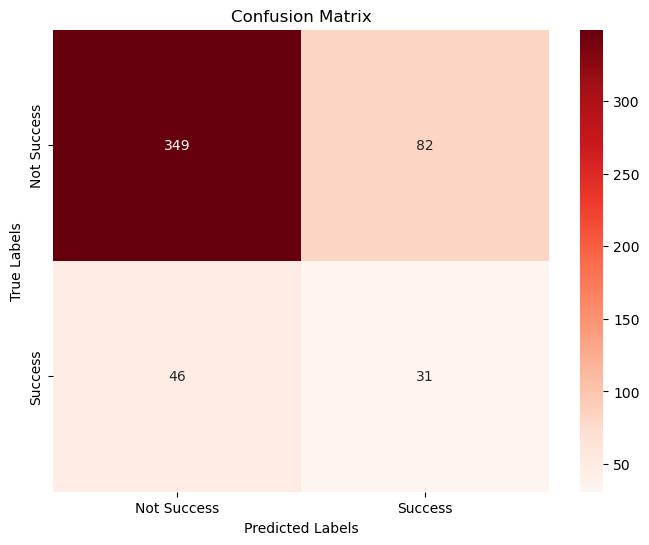

In [47]:
# 1. Trực quan hóa Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test, y_pred, labels=["Not Success", "Success"])

1. Tỷ lệ nhận diện "Thành công" (Success) thấp:
- Mô hình chỉ dự đoán chính xác 31 trong tổng số 77 trường hợp "Thành công", thể hiện khả năng nhận diện lớp này còn yếu.
- Recall cho lớp "Thành công" thấp (khoảng 40%).
2. Mất cân bằng dữ liệu:
- Số lượng "Không thành công" lớn hơn nhiều so với "Thành công". Điều này ảnh hưởng đến khả năng học của mô hình, dẫn đến thiên lệch về lớp "Không thành công".

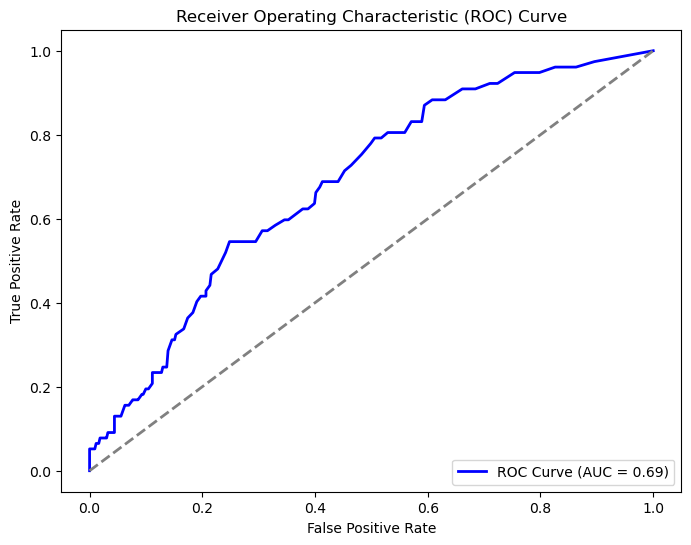

In [49]:
# 2. Trực quan hóa ROC Curve
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Dự đoán xác suất cho lớp 1 (Success)
y_pred_prob = model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_prob)

1. AUC Score = 0.69:
- Chỉ số AUC = 0.69 cho thấy mô hình có khả năng phân biệt giữa lớp "Thành công" và "Không thành công" nhưng vẫn còn hạn chế.
- Mô hình tốt sẽ có AUC > 0.8, trong khi AUC = 0.5 thể hiện mô hình không phân biệt được gì hơn ngẫu nhiên.

2. Đường cong ROC:
- Đường cong nằm trên đường chéo (đường nét đứt) cho thấy mô hình có hiệu suất tốt hơn ngẫu nhiên.
- Tuy nhiên, khoảng cách giữa đường ROC và đường chéo không lớn, đặc biệt ở phần đầu, cho thấy mô hình vẫn bỏ lỡ một số dự đoán dương tính.

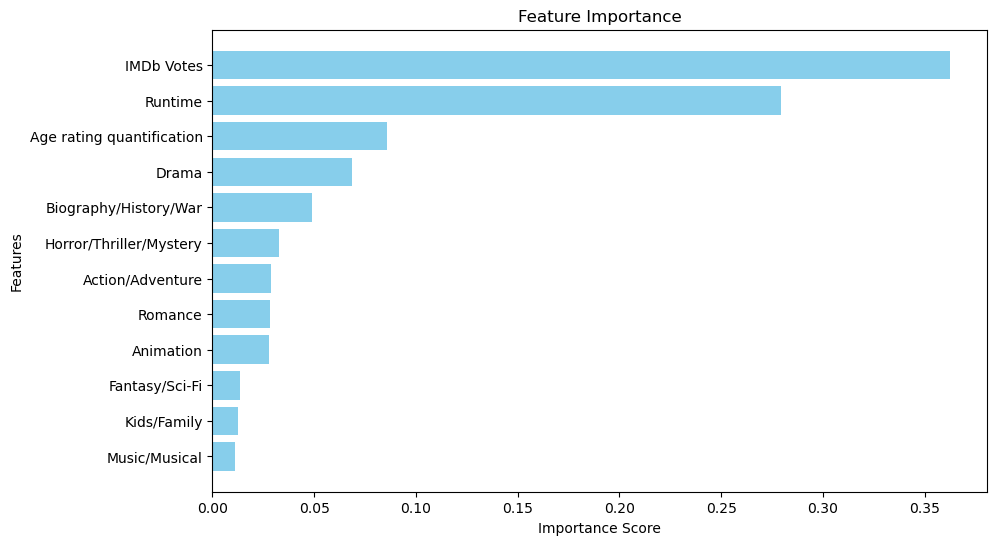

In [19]:
# 3. Trực quan hóa Feature Importance
def plot_feature_importance(model, feature_names):
    importance = model.feature_importances_
    sorted_idx = importance.argsort()[::-1]
    sorted_importance = importance[sorted_idx]
    sorted_features = [feature_names[i] for i in sorted_idx]

    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_importance, color='skyblue')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()  
    plt.show()

plot_feature_importance(model, features)

1. Đặc trưng quan trọng nhất:
- IMDb Votes (Số lượt bình chọn): Chiếm tỷ lệ cao nhất (~0.36). Điều này hợp lý vì lượt bình chọn thường phản ánh mức độ quan tâm của khán giả đối với bộ phim, từ đó ảnh hưởng lớn đến khả năng thành công.
- Runtime (Thời lượng phim): Có tầm quan trọng đáng kể (~0.28). Điều này cho thấy thời lượng phim có thể tác động đến thị hiếu khán giả.
- Age rating quantification (Xếp hạng độ tuổi): Cũng là một yếu tố quan trọng, gợi ý rằng độ tuổi mục tiêu có thể ảnh hưởng đến thành công của phim.

2. Các yếu tố khác:
- Drama, Biography/History/War, và Horror/Thriller/Mystery là các thể loại nổi bật, có ảnh hưởng đáng kể nhưng ít hơn so với các yếu tố chính.
- Các thể loại như Kids/Family, Music/Musical, và Fantasy/Sci-Fi có tầm quan trọng thấp, cho thấy chúng ít đóng góp vào khả năng dự đoán thành công của phim.